In [ ]:
import numpy as np
import matplotlib.pylab as plt

import torch
import torch.nn as nn

import torchvision

## Tutorial on Normalizing Flows

We now implement RealNVP model on a toy dataset.

In [ ]:
train_dset = torchvision.datasets.MNIST('./', download=True, train=True)
test_dset = torchvision.datasets.MNIST('./', download=True, train=False)

#reshape
X_train =  torch.nn.functional.max_pool2d(train_dset.data.float(), 2).numpy().reshape(-1, 14*14)/255.
X_test =  torch.nn.functional.max_pool2d(test_dset.data.float(), 2).numpy().reshape(-1, 14*14)/255.



train_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_train)*2. - 1.)
test_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_test)*2-1.)

train_loader = torch.utils.data.DataLoader(train_dset, 512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dset, 512, shuffle=True)

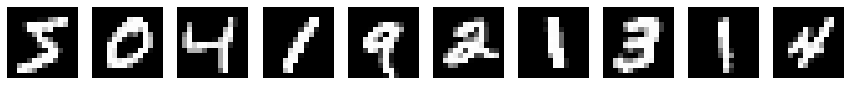

In [ ]:
# take a look a the images
fig, ax = plt.subplots(ncols=10, figsize=(15, 5))
for i in range(10):
    ax[i].imshow(train_dset[i][0].reshape(14, 14), cmap='gray')
    ax[i].axis('off')

## Task 1. Implement Affine Coupling Layer
$$
    z_{1:d} = x_{1:d},\\
    z_{d+1:D} = x_{d+1:D}\odot  \exp(s(x_{1:d})) + t(x_{1:d}).
$$

Let us use **Checkerboard** (left one), to split the input:

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/09879f7956dddc2a9328f5c1472feeb8402bcbcf/5-Figure3-1.png)



In [ ]:
class AffineCoupling1d(nn.Module):
    def __init__(self, dim, hid_dim, mode=1.):
        """
        dim (int) - dimnetion of the input data
        mode - 0 or 1 (from which number the mask starts)
        """
        super(AffineCoupling1d, self).__init__()
        self.mask = torch.arange(mode, mode+dim).unsqueeze(0) % 2
        self.s = nn.Sequential(
                nn.utils.weight_norm(nn.Linear(dim, hid_dim)),
                nn.LeakyReLU(),
                nn.utils.weight_norm(nn.Linear(hid_dim, hid_dim)),
                nn.LeakyReLU(),
                nn.utils.weight_norm(nn.Linear(hid_dim, dim)),
                nn.Tanh()
        )
        self.t = nn.Sequential(
                nn.utils.weight_norm(nn.Linear(dim, hid_dim)),
                nn.LeakyReLU(),
                nn.utils.weight_norm(nn.Linear(hid_dim, hid_dim)),
                nn.LeakyReLU(),
                nn.utils.weight_norm(nn.Linear(hid_dim, dim))
        )
        
    def forward(self, x):
        """
        Make a forward pass and compute log determinant of the transformation
        """
        # YOUR CODE HERE
        self.mask = self.mask.to(x.device)
        bx = self.mask * x
        s_bx = self.s(bx)
        t_bx = self.t(bx)
        z = bx + (1 - self.mask)*(x * torch.exp(s_bx) + t_bx)
        log_det = ((1 - self.mask)*s_bx).sum(1)
        return z, log_det      
        
    def inverse(self, z):
        """
        Covert noize to data via inverse transformation
        """
        # YOUR CODE HERE
        self.mask = self.mask.to(z.device)
        bz = self.mask * z
        s_bz = self.s(bz)
        t_bz = self.t(bz)
        x = bz + (1 - self.mask)*((z - t_bz)*torch.exp(-s_bz))
        return x
    

In [ ]:
class Flow(nn.Module):
    def __init__(self, layers, prior):
        super(Flow, self).__init__()    
        self.layers = nn.ModuleList(layers)
        self.prior = prior
    
    def forward(self, x):
        """
        Apply sequence of transformations and perform summation of log determinants
        """
        # YOUR CODE HERE
        log_det = 0.
        z = x.clone()
        for f in self.layers:
            z, d = f(z)
            log_det += d
        return z, log_det
    
    def inverse(self, z):
        """
        Apply sequence of transformations in the inverse order
        """
        # YOUR CODE HERE
        x = z.clone()
        for f in reversed(self.layers):
            x = f.inverse(x)
        return x
    
    def log_p(self, x):
        """
        Compute log probability of a given batch
        """
        # YOUR CODE HERE
        z, log_det = self(x)
        log_px = self.prior.log_prob(z).sum(1) + log_det
        return log_px
    
    def sample(self, N):
        """
        Sample from Flow
        """
        # YOUR CODE HERE
        z = self.prior.sample_n(N)
        x = self.inverse(z)
        return x

Initialize the Flow. You can vary number of coupling layers and hidden dimension

In [ ]:
x_dim = train_dset[i][0].shape[0]
N_layers = 3
hid_dim = 128
DEVICE = 'cuda'

prior = torch.distributions.Normal(torch.zeros(x_dim, device=DEVICE), torch.ones(x_dim, device = DEVICE))
layers = [AffineCoupling1d(x_dim, hid_dim, i%2) for i in range(N_layers)]
nf = Flow(layers, prior)

Check that transformation if invertable: $x = f^{-1}(f(x))$

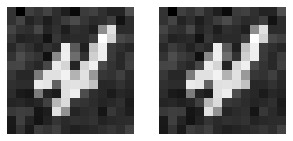

In [ ]:
test_input = train_dset[i][0].unsqueeze(0)
test_output = nf.inverse(nf(test_input)[0])
fig, ax = plt.subplots(ncols=2, figsize=(5,5))
ax[0].imshow(test_input[0].cpu().reshape(14, 14), cmap='gray');
ax[1].imshow(test_output[0].cpu().data.reshape(14, 14), cmap='gray');
ax[0].axis('off')
ax[1].axis('off');

Train the Flow

In [ ]:
from IPython.display import clear_output
def train_nf(model, train_loader, max_epoch, device):
    model = model.to(device)
    loss_hist = []
    optim = torch.optim.Adam(model.parameters(), lr=5e-5)
    for e in range(max_epoch):
        tot_loss = 0.
        for X, in train_loader:
            optim.zero_grad()
            eps = torch.randn_like(X)*0.1
            X = (X+eps).to(device) 
            log_p = model.log_p(X)
            loss = -log_p.mean()
            loss.backward()
            optim.step()
            tot_loss += loss.item()

        loss_hist.append(tot_loss/len(train_loader))
        if e%10 == 0:
            fig, ax = plt.subplots(ncols=2, figsize=(8,4))
            ax[0].plot(loss_hist)
            Xs = model.sample(1).data.cpu()
            Xs = torch.tanh(Xs)
            ax[1].imshow(Xs[0].reshape(14, 14), cmap='gray')
            ax[1].axis('off')
            plt.pause(0.3);
            clear_output(wait=True);

/home/annapriv/.local/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


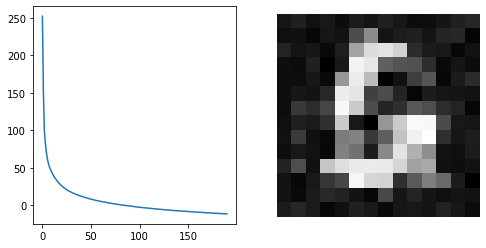

In [ ]:
train_nf(nf, train_loader, 200, DEVICE)

Plot samples

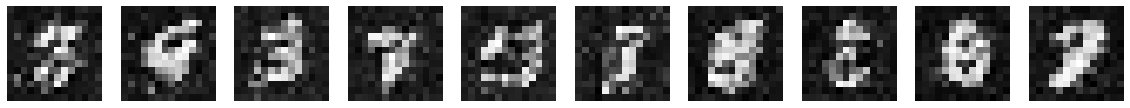

In [ ]:
nf.eval()
Xs = nf.sample(10).data.cpu()
Xs = torch.nn.functional.tanh(Xs)
fig, ax = plt.subplots(ncols=10, figsize=(20, 3))
for i in range(10):
    ax[i].imshow(Xs[i].reshape(14, 14), cmap='gray')
    ax[i].axis('off')

Plot interpolations in the latent space

In [ ]:

def plot_interpolation(x1, x2):
    fig, ax = plt.subplots(ncols=10, figsize=(15, 5))
    z_1 = nf(x1.to(DEVICE))[0]
    z_2 = nf(x2.to(DEVICE))[0]
    alpha = torch.linspace(0., 1., 10).to(DEVICE).view(10, 1)      
    interpolations_z = (z_1 * alpha + z_2 * (1 - alpha))
    interpolations_x = nf.inverse(interpolations_z)
    for i in range(10):
        ax[i].imshow(interpolations_x[i].data.cpu().reshape(14, 14), cmap='gray')
        ax[i].axis('off')

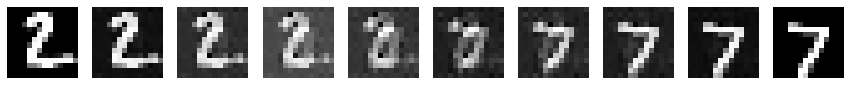

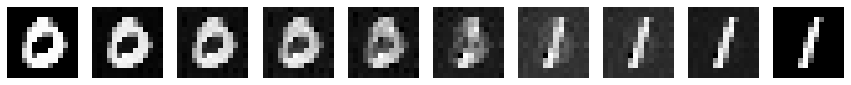

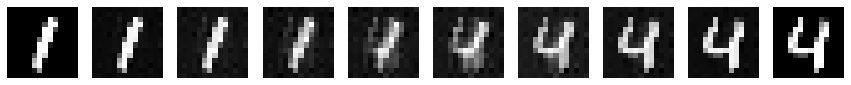

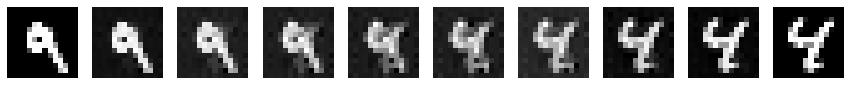

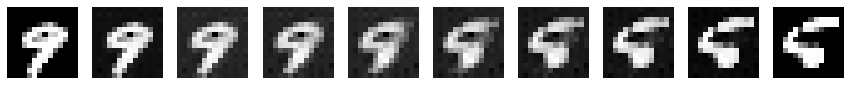

In [ ]:
for k in range(5):
    plot_interpolation(test_dset[k*2][0], test_dset[k*2+1][0])